Research question: is textual data enough to differentiate between fake news & true news?

helpful source code for text classification & analysis:
https://github.com/Christophe-pere/Text-classification

## Imports & Data load 

In [ ]:
# import needed libraries
import numpy as np
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize, TweetTokenizer
from nltk import bigrams, trigrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter, defaultdict
from prettytable import PrettyTable
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.parsing.preprocessing import remove_stopwords,strip_punctuation
import spacy
from nltk.probability import FreqDist
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from nltk.metrics import ConfusionMatrix

In [ ]:
# only needed when run in colab
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# loading the datasets
fake = pd.read_csv('Fake_news.csv')
true = pd.read_csv('True_news.csv')

corpus = fake.append(true)
corpus["fake"] = [1 for i in range(len(fake))]+[0 for i in range(len(true))]

In [ ]:
# plot fake data
fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [ ]:
# plot true data
true

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [ ]:
print("Fake news info:\n")
print(fake.info(), "\n\n")
print("True news info:\n")
print(true.info())

Fake news info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None 


True news info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


In [ ]:
fake.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


In [ ]:
true.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


In [ ]:
# remove duplicates
corpus = corpus.drop_duplicates(subset = ["text"])

fake = corpus[corpus["Fake"]==1]
print("Fake news length after duplicate removal:",len(fake))
true = corpus[corpus["Fake"]==0]
print("True news length after duplicate removal:",len(true))
# --> almost nothing filtered from true while fake news were reduced drastically.

Fake news length after duplicate removal: 17455
True news length after duplicate removal: 21191


In [ ]:
# text length distribution per class
fake_lengths = [len(text) for text in fake["text"]]
true_lengths = [len(text) for text in true["text"]]
np.sort(true_lengths)

array([  152,   152,   156, ..., 21559, 21661, 29781])

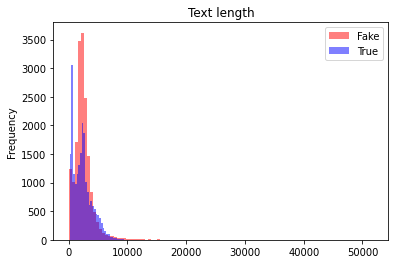

In [ ]:
# plot text length distribution per class - bar chart
kwargs = dict(alpha=0.5, bins=100)

plt.hist(fake_lengths, **kwargs, color='r', label='Fake')
plt.hist(true_lengths, **kwargs, color='b', label='True')
plt.gca().set(title='Text length', ylabel='Frequency')
plt.legend();
#plt.savefig('Text_lentgh_distribution.png', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


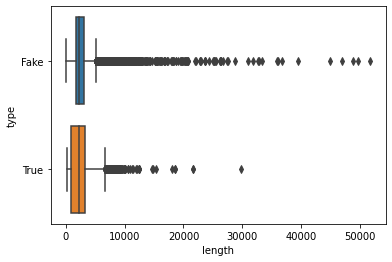

In [ ]:
# plot text length distribution per class - boxplot
temp = pd.DataFrame({"length":fake_lengths+true_lengths,"type":["Fake" for i in range(len(fake_lengths))]+["True" for i in range(len(true_lengths))]})
sns.boxplot(temp["length"],temp["type"])


## Preprocessing

In [ ]:
# remove stopwords
fake_destopped = [remove_stopwords(strip_punctuation(text)) for text in fake["text"]]
true_destopped = [remove_stopwords(strip_punctuation(text)) for text in true["text"]]

corpus_destopped = fake_destopped + true_destopped

In [ ]:
# Sent Tokenization

# with stopwords
fake_sent_tokens_sw = [sent_tokenize(text) for text in fake["text"]]
true_sent_tokens_sw = [sent_tokenize(text) for text in true["text"]]

# without stopwords
fake_sent_tokens = [[remove_stopwords(strip_punctuation(sent)) for sent in text] for text in fake_sent_tokens_sw]
true_sent_tokens = [[remove_stopwords(strip_punctuation(sent)) for sent in text] for text in true_sent_tokens_sw]

In [ ]:
# Word Tokenization 

# with stopwords
true_word_tokens_sw = [word_tokenize(text) for text in true["text"]]

# a lot of twitter posts in fake data --> use casual tokenizer to get rid of twitter handles and if existent two many repeating chars
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
fake_word_tokens_sw = [tknzr.tokenize(text) for text in fake["text"]]


# without stopwords
true_word_tokens = [word_tokenize(text) for text in true_destopped]

# a lot of twitter posts in fake data --> use casual tokenizer to get rid of twitter handles and if existent two many repeating chars
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
fake_word_tokens = [tknzr.tokenize(text) for text in fake_destopped]

In [ ]:
# Lemmatization 

# with stopwords
lm = WordNetLemmatizer()
fake_word_tokens_lem_sw = [[lm.lemmatize(token) for token in text] for text in fake_word_tokens_sw]
true_word_tokens_lem_sw = [[lm.lemmatize(token) for token in text] for text in true_word_tokens_sw]

fake_lem_concat_sw = [" ".join(text) for text in fake_word_tokens_lem_sw]
true_lem_concat_sw = [" ".join(text) for text in true_word_tokens_lem_sw]

corpus_lem_sw = fake_lem_concat_sw + true_lem_concat_sw

# without stopwords
lm = WordNetLemmatizer()
fake_word_tokens_lem = [[lm.lemmatize(token) for token in text] for text in fake_word_tokens]
true_word_tokens_lem = [[lm.lemmatize(token) for token in text] for text in true_word_tokens]

fake_lem_concat = [" ".join(text) for text in fake_word_tokens_lem]
true_lem_concat = [" ".join(text) for text in true_word_tokens_lem]

corpus_lem = fake_lem_concat + true_lem_concat

In [ ]:
# Downsample data

# with stopwords
fake_df_sw = pd.DataFrame({"text":fake_lem_concat_sw,"fake":fake["fake"]})
true_df_sw = pd.DataFrame({"text":true_lem_concat_sw,"fake":true["fake"]})

print("True dataset (with stopwords) size before Downsampling:",len(true_df_sw))
true_df_downsampled_sw = true_df_sw.sample(fake_df_sw.shape[0])
print("Fake dataset (with stopwords) size:",len(fake_df_sw))
print("True dataset (with stopwords) size after Downsampling:",len(true_df_downsampled_sw))
corpus_balanced_sw = pd.concat([true_df_downsampled_sw, fake_df_sw])
print("Total corpus (with stopwords) length after downsampling:",len(corpus_balanced_sw))

# without stopwords
fake_df = pd.DataFrame({"text":fake_lem_concat,"fake":fake["fake"]})
true_df = pd.DataFrame({"text":true_lem_concat,"fake":true["fake"]})

print("True dataset (with stopwords) size before Downsampling:",len(true_df))
true_df_downsampled = true_df.sample(fake_df.shape[0])
print("Fake dataset (with stopwords) size:",len(fake_df))
print("True dataset (with stopwords) size after Downsampling:",len(true_df_downsampled))
corpus_balanced = pd.concat([true_df_downsampled, fake_df])
print("Total corpus (with stopwords) length after downsampling:",len(corpus_balanced))

## Analysis

### Most frequent n-grams for each class
taken from https://github.com/Christophe-pere/Text-classification/blob/master/Text_Classification.ipynb

#### General Functions

In [ ]:
def get_top_n_words(corpus, n=None):
        '''
        Function to return a list of most frequent unigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        vec = TfidfVectorizer().fit(corpus)             # bag of words
        bag_of_words = vec.transform(corpus)
        mean_words = bag_of_words.mean(axis=0) 
        words_freq = [(word, mean_words[0,idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]

In [ ]:
def get_top_n_bigram(corpus, n=None):
        '''
        Function to return a list of most frequent bigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        vec = TfidfVectorizer(ngram_range=(2, 2)).fit(corpus) 
        bag_of_words = vec.transform(corpus)
        mean_words = bag_of_words.mean(axis=0) 
        words_freq = [(word, mean_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]

In [ ]:
def get_top_n_trigram(corpus, n=None):
        '''
        Function to return a list of most frequent trigrams in documents
        @param corpus: (str or pandas.dataframe) documents 
        @param n: (int) number of most frequent unigrams
        @return: (list) most frequent unigrams
        '''
        vec = TfidfVectorizer(ngram_range=(3, 3)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        mean_words = bag_of_words.mean(axis=0) 
        words_freq = [(word, mean_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]


In [ ]:
def plot_top_word_freq(df,title):
    plt.figure(figsize=(10,6))
    plt.barh(df1["words"][::-1], df1["count"][::-1], color="tab:orange")
    plt.ylabel("Words")
    plt.xlabel("Average Frequency")
    plt.title(title)
    plt.grid(True,axis="x")
    #plt.savefig('Trigram_Avg_Freq_True.png', bbox_inches='tight')

#### Unigrams

In [ ]:
# get Top 20 words frequencies for Fake news including stopwords 
common_words = get_top_n_words(fake["text"], 20)
df1 = pd.DataFrame(common_words, columns = ['words' , 'count'])

In [ ]:
# plot Top 20 words frequencies
plot_top_word_freq(df1,"Top 20 words in Fake News before removing stopwords")

In [ ]:
# get Top 20 words frequencies for True news including stopwords 
common_words = get_top_n_words(true["text"], 20)
df1 = pd.DataFrame(common_words, columns = ['words' , 'count'])

In [ ]:
# plot Top 20 words frequencies
plot_top_word_freq(df1,"Top 20 words in True News before removing stopwords")

In [ ]:
# get Top 20 words frequencies for Fake news without stopwords 
common_words_destopped = get_top_n_words(fake_destopped, 20)
df1 = pd.DataFrame(common_words_destopped, columns = ['words' , 'count'])

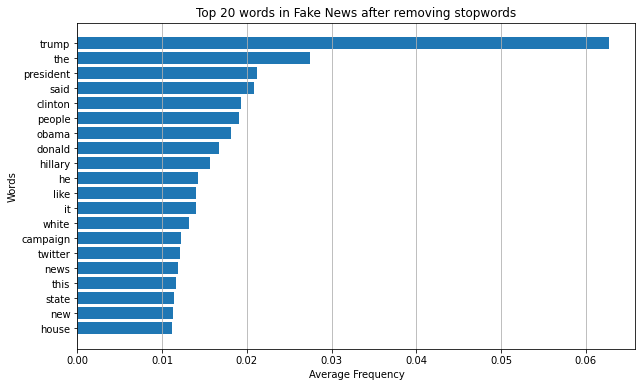

In [ ]:
# plot Top 20 words frequencies
plot_top_word_freq(df1,"Top 20 words in Fake News after removing stopwords")

In [ ]:
# get Top 20 words frequencies for Fake news without stopwords 
common_words_destopped = get_top_n_words(true_destopped, 20)
df1 = pd.DataFrame(common_words_destopped, columns = ['words' , 'count'])

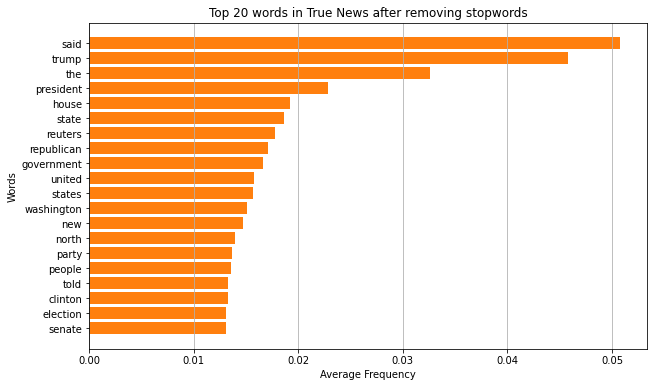

In [ ]:
# plot Top 20 words frequencies
plot_top_word_freq(df1,"Top 20 words in True News after removing stopwords")

#### Bigrams

In [ ]:
# get Top 20 bigrams frequencies for Fake news including stopwords 
common_words = get_top_n_bigram(fake["text"], 20)
df1 = pd.DataFrame(common_words, columns = ['words' , 'count'])

In [ ]:
# plot Top 20 bigram frequencies
plot_top_word_freq(df1,"Top 20 bigrams in Fake News before removing stopwords")

In [ ]:
# get Top 20 bigrams frequencies for True news including stopwords 
common_words = get_top_n_bigram(true["text"], 20)
df1 = pd.DataFrame(common_words, columns = ['words' , 'count'])

In [ ]:
# plot Top 20 bigram frequencies
plot_top_word_freq(df1,"Top 20 bigrams in True News before removing stopwords")

In [ ]:
# get Top 20 bigrams frequencies for Fake news without stopwords 
common_words_destopped = get_top_n_bigram(fake_destopped, 20)
df1 = pd.DataFrame(common_words_destopped, columns = ['words' , 'count'])

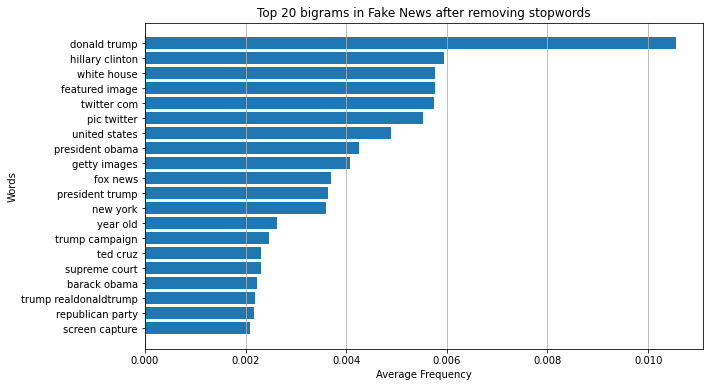

In [ ]:
# plot Top 20 bigram frequencies
plot_top_word_freq(df1,"Top 20 bigrams in Fake News after removing stopwords")

In [ ]:
# get Top 20 bigrams frequencies for True news without stopwords 
common_words_destopped = get_top_n_bigram(true_destopped, 20)
df1 = pd.DataFrame(common_words_destopped, columns = ['words' , 'count'])

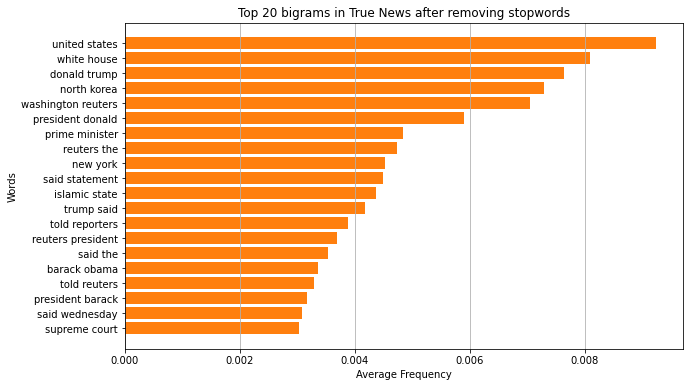

In [ ]:
# plot Top 20 bigram frequencies
plot_top_word_freq(df1,"Top 20 bigrams in True News after removing stopwords")

#### Trigram (destopped only)

In [ ]:
# get Top 20 trigrams frequencies for Fake news without stopwords
common_words_destopped = get_top_n_trigram(fake_destopped, 20)
df1 = pd.DataFrame(common_words_destopped, columns = ['words' , 'count'])

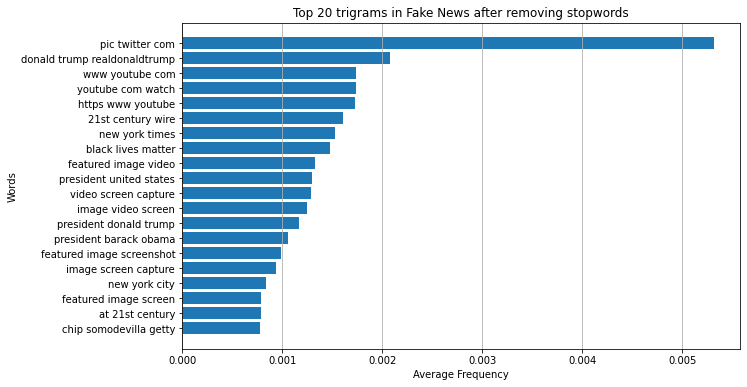

In [ ]:
# plot Top 20 trigram frequencies
plot_top_word_freq(df1,"Top 20 trigrams in Fake News after removing stopwords")

In [ ]:
# get Top 20 trigrams frequencies for True news without stopwords
common_words_destopped = get_top_n_trigram(true_destopped, 20)
df1 = pd.DataFrame(common_words_destopped, columns = ['words' , 'count'])

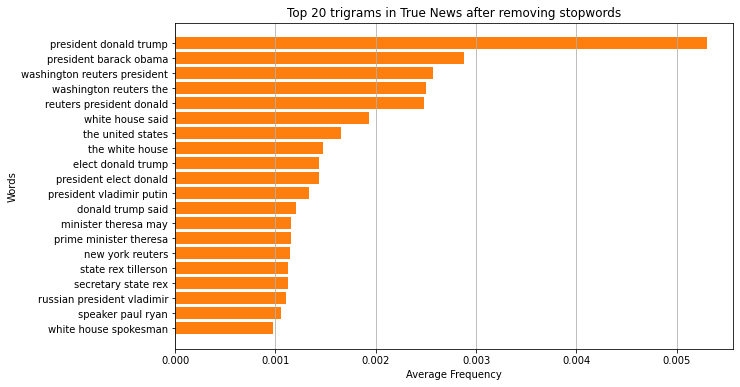

In [ ]:
# plot Top 20 trigram frequencies
plot_top_word_freq(df1,"Top 20 trigrams in True News after removing stopwords")

### POS tagging

#### Fake News

In [ ]:
# Load spaCy English model
sp = spacy.load('en_core_web_sm')

In [ ]:
# convert sentences into spaCy docs
#fake_spacy_docs = [[sp(sent) for sent in sentences] for sentences in tqdm(fake_sent_tokens_sw)]
#fake_spacy_docs[:1]
# spaCy docs are huge for some reason

In [ ]:
# convert each spaCy doc into the respective POS tags
#fake_pos = [[str(s.pos_) for sent in sentences for s in sent] for sentences in tqdm(fake_spacy_docs)]

In [ ]:
# save result in order not to run conversion it again
#np.save('fake_pos.npy', np.array(fake_pos, dtype=object))

In [ ]:
# load tagged array
fake_pos = np.load('fake_pos.npy',allow_pickle=True)

In [ ]:
# Join tags for each text
fake_pos_concat = [" ".join(tags) for tags in fake_pos]

In [ ]:
# Calculate POS frequency
tfidf_pos = TfidfVectorizer()
fake_pos_vec = tfidf_pos.fit_transform(fake_pos_concat)

In [ ]:
# Set up DataFrame with tags and average Frequencies
tags = tfidf_pos.get_feature_names()
pos_avg_frequencies = np.mean(fake_pos_vec.toarray(),axis=0)
df1 = pd.DataFrame({"POS":tags, "Frequency":pos_avg_frequencies})
df1 = df1.sort_values("Frequency",ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


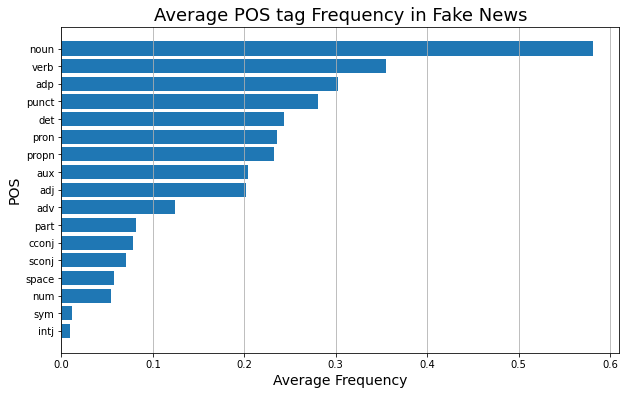

In [ ]:
# Plot average POS tag frequencies for Fake data
plt.figure(figsize=(10,6))
plt.barh(df1["POS"][::-1], df1["Frequency"][::-1])
plt.ylabel("POS",fontsize=14)
plt.xlabel("Average Frequency",fontsize=14)
plt.title("Average POS tag Frequency in Fake News",fontsize=18)
plt.grid(True, axis='x')
#plt.savefig('Avg_POS_Freq_Fake.png', bbox_inches='tight')

#### True News

In [ ]:
# load tagged array
true_pos = np.load('true_pos.npy',allow_pickle=True)

In [ ]:
# Join tags for each text
true_pos_concat = [" ".join(tags) for tags in true_pos]

In [ ]:
# Calculate POS frequency
tfidf_pos = TfidfVectorizer()
true_pos_vec = tfidf_pos.fit_transform(true_pos_concat)

In [ ]:
# Set up DataFrame with tags and average Frequencies
tags = tfidf_pos.get_feature_names()
pos_avg_frequencies = np.mean(true_pos_vec.toarray(),axis=0)
df1 = pd.DataFrame({"POS":tags, "Frequency":pos_avg_frequencies})
df1 = df1.sort_values("Frequency",ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


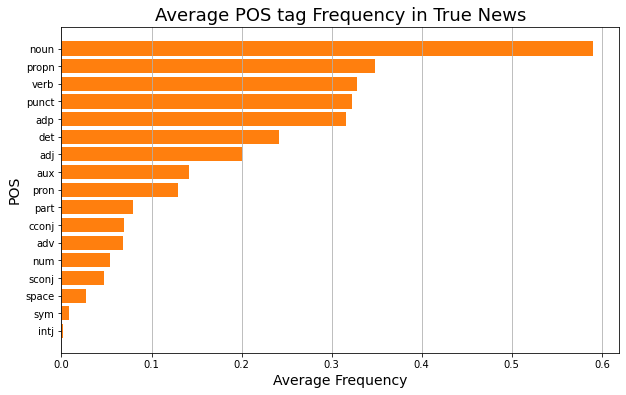

In [ ]:
# Plot average POS tag frequencies for True data
plt.figure(figsize=(10,6))
plt.barh(df1["POS"][::-1], df1["Frequency"][::-1], color="tab:orange")
plt.ylabel("POS",fontsize=14)
plt.xlabel("Average Frequency",fontsize=14)
plt.title("Average POS tag Frequency in True News",fontsize=18)
plt.grid(True, axis="x")
#plt.savefig('Avg_POS_Freq_True.png', bbox_inches='tight')

### t-SNE
taken from https://www.scikit-yb.org/en/latest/api/text/tsne.html

#### General function

In [ ]:
# Utility function to visualize the outputs of t-SNE

def cluster_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(int)], alpha=0.6)
    plt.title("t-SNE clusters after stopword removal",fontsize=18)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        label = "Fake"
        if i==1:
            label = "True"
        txt = ax.text(xtext, ytext, label, fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=2, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    
    #plt.savefig('tsne_clusters.png', bbox_inches='tight')
    plt.show()
    return

#### With Stopwords

In [ ]:
# vectorize corpus
corpus_vec_sw = TfidfVectorizer().fit_transform(corpus_lem_sw)

In [ ]:
# first step dimensionality reduction with SVM -> 50 components
corpus_reduced_sw = TruncatedSVD(n_components=50).fit_transform(corpus_vec_sw)

In [ ]:
corpus_reduced_sw.shape

(38646, 50)

In [ ]:
# second step dimensionality reduction with tsne --> 2 components
corpus_reduced_sw = TSNE(n_components=2).fit_transform(corpus_reduced_sw)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
#np.save('tsne_corpus_sw.npy', np.array(corpus_reduced_sw, dtype=object))

In [ ]:
corpus_reduced_sw = np.load('tsne_corpus_sw.npy',allow_pickle=True)

In [ ]:
corpus_reduced_sw.shape

(38646, 2)

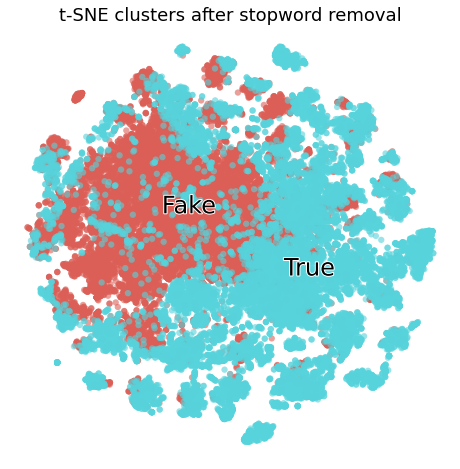

In [ ]:
# plot clusters to show difference between true and fake texts
cluster_scatter(corpus_reduced_sw, np.array(corpus["label"]))

#### Without Stopwords

In [ ]:
# vectorize corpus
corpus_vec = TfidfVectorizer().fit_transform(corpus_lem)

In [ ]:
# first step dimensionality reduction with SVM -> 50 components
corpus_reduced = TruncatedSVD(n_components=50).fit_transform(corpus_vec)

In [ ]:
corpus_reduced.shape

(38646, 50)

In [ ]:
# second step dimensionality reduction with tsne --> 2 components
corpus_reduced = TSNE(n_components=2).fit_transform(corpus_reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
#np.save('tsne_corpus.npy', np.array(corpus_reduced, dtype=object))

In [ ]:
corpus_reduced = np.load('tsne_corpus.npy',allow_pickle=True)

In [ ]:
corpus_reduced.shape

(38646, 2)

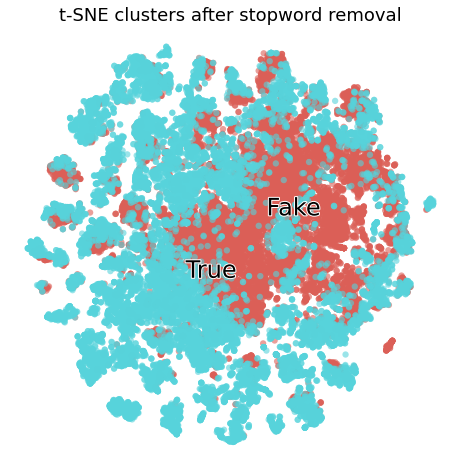

In [ ]:
# plot clusters to show difference between true and fake texts
cluster_scatter(corpus_reduced, np.array(corpus["label"]))

### LDA

In [ ]:
number_of_topics = 3

#### Overall

In [ ]:
# vectorize corpus
tfidf_lda = TfidfVectorizer()
corpus_vec = tfidf_lda.fit_transform(corpus_lem)

In [ ]:
# apply LDA
lda_aggregated = LDA(n_components=number_of_topics,random_state=42)
corpus_topic_vec = lda_aggregated.fit_transform(corpus_vec)

In [ ]:
# plot Top 10 words for each generated topic
for index,topic in enumerate(lda_aggregated.components_):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([tfidf_lda.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['image', 'like', 'http', 'realdonaldtrump', 'woman', 'video', 'pic', 'com', 'twitter', 'trump']


THE TOP 10 WORDS FOR TOPIC #1
['election', 'year', 'obama', 'clinton', 'house', 'state', 'republican', 'president', 'said', 'trump']


THE TOP 10 WORDS FOR TOPIC #2
['turkey', 'china', 'islamic', 'al', 'syrian', 'military', 'iran', 'syria', 'saudi', 'said']




In [ ]:
# obtain categories for all texts
corpus_categorized = corpus.copy()[["text","label"]]
corpus_categorized["topic"] = corpus_topic_vec.argmax(axis=1)

In [ ]:
# get topic IDs and number of texts in the category
topics = corpus_categorized.groupby("topic")["text"].count().sort_values(ascending=True).index
counts = corpus_categorized.groupby("topic")["text"].count().sort_values(ascending=True)

In [ ]:
# show value counts per topic
corpus_categorized.groupby(["topic","label"])["text"].count().sort_values(ascending=False)

topic  label
1      1        17508
       0        14392
2      1         3678
0      0         2876
2      0          187
0      1            5
Name: text, dtype: int64

Text(0.5, 0, 'Number of texts')

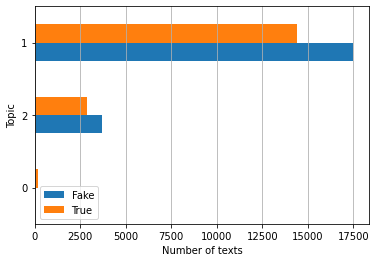

In [ ]:
# plot count per topic for each class
fake_count = [5,3678,17508]
true_count = [187,2876,14392]
index = topics
df = pd.DataFrame({'Fake': fake_count,
                   'True': true_count}, index=index)
ax = df.plot.barh(rot=0)
ax.grid(axis="x")
plt.ylabel("Topic")
plt.xlabel("Number of texts")
#plt.savefig('Topic_counts.png', bbox_inches='tight')

In [ ]:
# show topic clusters with t-sne
palette = np.array(sns.color_palette("hls", number_of_topics))
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(corpus_reduced[:,0], corpus_reduced[:,1], lw=0, s=40, c=palette[np.array(corpus_categorized["topic"]).astype(int)], alpha=0.5)
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.axis('off')
ax.axis('tight')
#plt.savefig('Topic_cluster.png', bbox_inches='tight')

#### Fake News

In [ ]:
# vectorize corpus
tfidf_lda = TfidfVectorizer()
corpus_vec = tfidf_lda.fit_transform(fake_lem_concat)

In [ ]:
# apply LDA
lda_fake = LDA(n_components=number_of_topics,random_state=42)
corpus_topic_vec = lda_fake.fit_transform(corpus_vec)

In [ ]:
# plot Top 10 words for each generated topic
for index,topic in enumerate(lda_fake.components_):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([tfidf_lda.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['xfbml', 'parentnode', 'insertbefore', 'getelementbyid', 'getelementsbytagname', 'createelement', 'id', 'var', 'cdata', 'fjs']


THE TOP 10 WORDS FOR TOPIC #1
['hesher', 'tune', 'radio', 'join', 'broadcast', '00', 'room', 'pm', 'acr', 'boiler']


THE TOP 10 WORDS FOR TOPIC #2
['hillary', 'state', 'donald', 'republican', 'obama', 'people', 'clinton', 'said', 'president', 'trump']




In [ ]:
# obtain categories for all texts
fake_categorized = corpus.copy()[["text","label"]][corpus["label"]==0]
fake_categorized["topic"] = corpus_topic_vec.argmax(axis=1)

In [ ]:
# get topic IDs and number of texts in the category
topics = fake_categorized.groupby("topic")["text"].count().sort_values(ascending=True).index
counts = fake_categorized.groupby("topic")["text"].count().sort_values(ascending=True)

In [ ]:
# show value counts per topic
fake_categorized.groupby("topic")["text"].count().sort_values(ascending=False)

topic
2    17333
1      101
0       21
Name: text, dtype: int64

Text(0.5, 0, 'Number of texts')

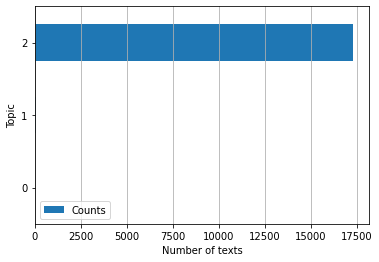

In [ ]:
# plot count per topic for Fake data
index = topics
df = pd.DataFrame({'Counts': counts}, index=index)
ax = df.plot.barh(rot=0)
ax.grid(axis="x")
plt.ylabel("Topic")
plt.xlabel("Number of texts")
#plt.savefig('Topic_counts.png', bbox_inches='tight')

could be done per category as well; also could use lemmatized text?

#### True News

In [ ]:
# vectorize corpus
tfidf_lda = TfidfVectorizer()
corpus_vec = tfidf_lda.fit_transform(true_lem_concat)

In [ ]:
# apply LDA
lda_true = LDA(n_components=number_of_topics,random_state=42)
corpus_topic_vec = lda_true.fit_transform(corpus_vec)

In [ ]:
# plot Top 10 words for each generated topic
for index,topic in enumerate(lda_true.components_):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([tfidf_lda.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['north', 'russia', 'korea', 'clinton', 'state', 'house', 'president', 'republican', 'said', 'trump']


THE TOP 10 WORDS FOR TOPIC #1
['minister', 'trump', 'eu', 'party', 'court', 'tax', 'year', 'government', 'state', 'said']


THE TOP 10 WORDS FOR TOPIC #2
['potus', 'edited', 'rosenstein', 'bit', 'est', 'nunes', 'realdonaldtrump', 'ly', 'mueller', 'edt']




In [ ]:
# obtain categories for all texts
true_categorized = corpus.copy()[["text","label"]][corpus["label"]==1]
true_categorized["topic"] = corpus_topic_vec.argmax(axis=1)

In [ ]:
# get topic IDs and number of texts in the category
topics = true_categorized.groupby("topic")["text"].count().sort_values(ascending=True).index
counts = true_categorized.groupby("topic")["text"].count().sort_values(ascending=True)

In [ ]:
# show value counts per topic
true_categorized.groupby("topic")["text"].count().sort_values(ascending=False)

topic
1    11268
0     9885
2       38
Name: text, dtype: int64

Text(0.5, 0, 'Number of texts')

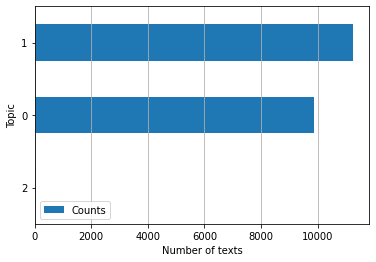

In [ ]:
# plot count per topic for True data
index = topics
df = pd.DataFrame({'Counts': counts}, index=index)
ax = df.plot.barh(rot=0)
ax.grid(axis="x")
plt.ylabel("Topic")
plt.xlabel("Number of texts")
#plt.savefig('Topic_counts.png', bbox_inches='tight')

In [ ]:
'''palette = np.array(sns.color_palette("hls", number_of_topics))
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(corpus_reduced[:,0], corpus_reduced[:,1], lw=0, s=40, c=palette[np.array(corpus_categorized["topic"]).astype(int)], alpha=0.5)
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.axis('off')
ax.axis('tight')
#plt.savefig('Topic_cluster.png', bbox_inches='tight')'''

could be done per category as well; also could use lemmatized text?

### Sentiment analysis

In [ ]:
def get_sent_sentiment_scores(sent_tokens):
    '''
    function to get the average sentiment score for each text
    '''
    sentiment_scores = {}
    sia = SentimentIntensityAnalyzer()

    for count, sentences_list in enumerate(sent_tokens):
        if len(sentences_list) > 0:
            text_sentiment = {}
            n_sent = 0
            for indx, sent in enumerate(sentences_list):
                if len(sent)> 3:
                    sentiment_dict = sia.polarity_scores(sent)
                    text_sentiment[indx] = sentiment_dict
                n_sent +=1

            pos = 0
            neg = 0
            neu = 0
            if text_sentiment:
                for _, value in text_sentiment.items():
                    pos += value["pos"]
                    neg += value["neg"]
                    neu += value["neu"]
            sentiment_scores[count] = {"pos": (pos/n_sent)*100, "neg": (neg/n_sent)*100, "neu": (neu/n_sent)*100}
    return sentiment_scores

In [ ]:
def get_overall_sentiment_score(sent_scores):
    '''
    function to get overall sentiment score of the dataset
    '''
    pos = 0
    neg = 0
    neu = 0
    for _, value in sent_scores.items():
        pos += value["pos"]
        neg += value["neg"]
        neu += value["neu"]

    return {"Positive": pos/len(sent_scores), "Negative": neg/len(sent_scores), "Neutral": neu/len(sent_scores)}

In [ ]:
# obtain all sentiment scores
fake_sent_sentiment_scores = get_sent_sentiment_scores(fake_sent_tokens)
true_sent_sentiment_scores = get_sent_sentiment_scores(true_sent_tokens)

In [ ]:
print(f"The overall sentiment in the fake dataset:\n", get_overall_sentiment_score(fake_sent_sentiment_scores))
print(f"The overall sentiment in the true dataset:\n", get_overall_sentiment_score(true_sent_sentiment_scores))

The overall sentiment in the fake dataset:
 {'Positive': 13.797137016539704, 'Negative': 13.51031880387908, 'Neutral': 71.77326776541045}
The overall sentiment in the true dataset:
 {'Positive': 11.628310403842134, 'Negative': 10.57358633405281, 'Neutral': 77.64743870150669}


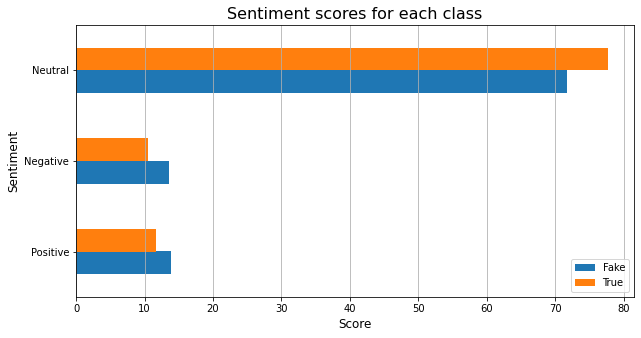

In [ ]:
# plot overall sentiment scores for each class
index = get_overall_sentiment_score(fake_sent_sentiment_scores).keys()
df = pd.DataFrame({'Fake': get_overall_sentiment_score(fake_sent_sentiment_scores).values(),
                   'True': get_overall_sentiment_score(true_sent_sentiment_scores).values()}, index=index)
ax = df.plot.barh(rot=0,figsize=(10,5))
ax.grid(axis="x")
plt.ylabel("Sentiment",fontsize=12)
plt.xlabel("Score",fontsize=12)
plt.title("Sentiment scores for each class",fontsize=16)
#plt.savefig('Sentiment_scores.png', bbox_inches='tight')

## Classification

In [ ]:
corpus_balanced = np.load('corpus_balanced.npy',allow_pickle=True)
corpus_balanced_sw = np.load('corpus_balanced_sw.npy',allow_pickle=True)

In [ ]:
corpus_balanced = pd.DataFrame({"text":corpus_balanced[:,0],"fake":corpus_balanced[:,1]})
corpus_balanced_sw = pd.DataFrame({"text":corpus_balanced_sw[:,0],"fake":corpus_balanced_sw[:,1]})

#### General functions

In [ ]:
def get_word_distribution(corpus):
    '''
    retrieve the word distribution for the given corpus
    '''
    all_words = []

    for message in corpus:
        words = word_tokenize(message)
        for w in words:
            all_words.append(w)
          
    all_words = nltk.FreqDist(all_words)

    # Print the overall number of words and the most common words
    print('Number of words: {}'.format(len(all_words)))
    print('Most common words: {}'.format(all_words.most_common(15)))
    return all_words

In [ ]:
def find_features(text, word_features):
    '''
    Function to determine which of the word features are present in the given text
    '''
    words = word_tokenize(text)
    features = {}
    for word in word_features:
        features[word] = (word in words)

    return features

#### With stopwords

In [ ]:
# get data and labels for Classification
X_sw = corpus_balanced_sw['text']
Y_sw = corpus_balanced_sw['fake']

In [ ]:
X_sw[:2]

0    COPENHAGEN ( Reuters ) - The populist Danish P...
1    BEIRUT ( Reuters ) - Hezbollah leader Sayyed H...
Name: text, dtype: object

In [ ]:
# get most common words from the corpus and use 1500 most common words as features
all_words_sw = get_word_distribution(X_sw)
word_features_sw = [x[0] for x in all_words_sw.most_common(1500)]

Number of words: 220854
Most common words: [('the', 697053), (',', 694163), ('.', 529887), ('to', 413993), ('a', 380795), ('of', 336669), ('and', 304707), ('in', 250676), ('that', 180509), ('s', 180102), ('on', 143844), ('for', 130242), ('is', 129309), ('Trump', 107534), ('it', 103589)]


In [ ]:
news_sw = list(zip(X_sw, Y_sw))

np.random.seed(1)
np.random.shuffle(news_sw)

# Call find_features function for each news text
feature_set_sw = [(find_features(text,word_features_sw), label) for (text, label) in tqdm(news_sw)]

100%|██████████| 34910/34910 [08:14<00:00, 70.56it/s]


In [ ]:
# split data into train and test set
train_sw, test_sw = train_test_split(feature_set_sw, test_size=0.25, random_state=1)

In [ ]:
# setup and run model
nb_sw = MultinomialNB()
nltk_model_sw = SklearnClassifier(nb_sw)
nltk_model_sw.train(train_sw)

<SklearnClassifier(MultinomialNB())>

In [ ]:
# print accuracy of NB
accuracy_sw = nltk.classify.accuracy(nltk_model_sw, test_sw)
print("Naive Bayes model Accuracy:",accuracy_sw)

Naive Bayes model Accuracy: 0.9826993583868011


In [ ]:
# Confusion Matrix
test_Y_sw = [text[1] for text in test_sw]
test_X_sw = [text[0] for text in test_sw]
test_predictions_sw = nltk_model_sw.classify_many(test_X_sw)
cm = ConfusionMatrix(test_Y_sw, test_predictions_sw)
print(cm)

  |    0    1 |
--+-----------+
0 |<4398>  21 |
1 |  130<4179>|
--+-----------+
(row = reference; col = test)



#### Without stopwords

In [ ]:
# get data and labels for Classification
X = corpus_balanced['text']
Y = corpus_balanced['fake']

In [ ]:
# get most common words from the corpus and use 1500 most common words as features
all_words = get_word_distribution(X)
word_features = [x[0] for x in all_words.most_common(1500)]

Number of words: 138333
Most common words: [('s', 181534), ('Trump', 112254), ('said', 105130), ('The', 88230), ('’', 57672), ('I', 48879), ('“', 44322), ('”', 44097), ('t', 43085), ('U', 42704), ('S', 40585), ('people', 31929), ('year', 31762), ('President', 27946), ('Reuters', 23876)]


In [ ]:
news = list(zip(X, Y))

np.random.seed(1)
np.random.shuffle(news)

# Call find_features function for each news text
feature_set = [(find_features(text,word_features), label) for (text, label) in tqdm(news)]

100%|██████████| 34910/34910 [04:26<00:00, 131.13it/s]


In [ ]:
# split data into train and test set
train, test = train_test_split(feature_set, test_size=0.25, random_state=1)

In [ ]:
# setup and run model
nb = MultinomialNB()
nltk_model = SklearnClassifier(nb)
nltk_model.train(train)

<SklearnClassifier(MultinomialNB())>

In [ ]:
# print accuracy of NB
accuracy = nltk.classify.accuracy(nltk_model, test)
print("Naive Bayes model Accuracy:",accuracy)

Naive Bayes model Accuracy: 0.9794912923923006


In [ ]:
# Confusion Matrix
test_Y = [text[1] for text in test]
test_X = [text[0] for text in test]
test_predictions = nltk_model_sw.classify_many(test_X)
cm = ConfusionMatrix(test_Y, test_predictions)
print(cm)

  |    0    1 |
--+-----------+
0 |<4403>  16 |
1 |  323<3986>|
--+-----------+
(row = reference; col = test)



### BERT

helpful source code for BERT implementation:
https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [ ]:
# install required dependencies
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

In [ ]:
# import required libraries

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
# Separate into a training and testing dataset
train_true_df = true_df.sample(frac = 0.75)
test_true_df = true_df.drop(train_fake_df.index)
train_fake_df = fake.sample(frac = 0.75)
test_fake_df = fake.drop(train_true_df.index)

In [ ]:
# Create required directory structure

d = test_fake_df['text']
file = 'set/test/fake/file{}.txt'

n = 0 # to number the files

for x in d:
    with open(file.format(n), 'w') as f:
        f.write(str(x))
    n += 1

d = test_true_df['text']
file = 'set/test/true/file{}.txt'

n = 0 # to number the files

for x in d:
    with open(file.format(n), 'w') as f:
        f.write(str(x))
    n += 1

d = train_true_df['text']
file = 'set/train/true/file{}.txt'

n = 0 # to number the files

for x in d:
    with open(file.format(n), 'w') as f:
        f.write(str(x))
    n += 1
d = train_fake_df['text']
file = 'set/train/fake/file{}.txt'

n = 0 # to number the files

for x in d:
    with open(file.format(n), 'w') as f:
        f.write(str(x))
    n += 1

In [ ]:
# import BERT models for Pre-processing and Encoding
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

In [ ]:
# define BERT models for Pre-processing and Encoding
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
# Binary loss function configured for binary classification problem
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# Define Model architecture
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
# Configuration of Adam optimizer and epochs 
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
# Compile model
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
# Model training
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

In [ ]:
# Model evaluation
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')